In [1]:
from sklearn import linear_model
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from numpy import sqrt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import numpy as np
from numpy import inf

## inflow modelling

In [2]:
# data frame with POI matrix and average population flow
dataset =pd.read_csv('output/dataset(x_y)_OP_L1_week_cleaned.csv')

data = dataset.drop(columns=['dayofweek','time_interval','zonecode'])
data.head()

,"('MONDAY', '400_S1')","('MONDAY', '500_S1')","('MONDAY', '550_S1')","('MONDAY', '600_S1')","('MONDAY', '700_S1')","('MONDAY', '800_S1')","('MONDAY', '900_S1')","('MONDAY', '100_S2')","('MONDAY', '200_S2')","('MONDAY', '300_S2')",...,"('SUNDAY', '800_S4')","('SUNDAY', '900_S4')","('SUNDAY', '100_S5')","('SUNDAY', '200_S5')","('SUNDAY', '500_S5')","('SUNDAY', '100_S6')","('SUNDAY', '200_S6')","('SUNDAY', '500_S6')",outflow_median,inflow_median
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# splite into x and y
x = data.drop(columns= ['inflow_median','outflow_median'])
y1 = data['inflow_median']

In [4]:
# splite into test data and train data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y1, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(172809, 304)
(57603, 304)
(172809,)
(57603,)


In [5]:
# fit into the model
lars = linear_model.Lars().fit(X_train, Y_train)

In [6]:
# save the coefficients 
para_in = lars.coef_

In [7]:
# evaluation of the model
ypred_1 = lars.predict(X_test)
mse = mean_squared_error(Y_test, ypred_1)
print("MSE: %.2f" % mse) 
# MSE represents the difference between the original and predicted values extracted by squared the average difference over the data set.
print("RMSE: %.2f" % sqrt(mse))
# RMSE is the error rate by the square root of MSE.

MSE: 0.13
RMSE: 0.36


In [9]:
def mape(y_true, y_pred):
    df = pd.DataFrame(columns = ['y_true', 'y_pred'])
    df['y_true'] = y_true
    df['y_pred'] = y_pred
    df = df[df.y_true > 0]
    return np.mean(np.abs((df.y_pred - df.y_true) / df.y_true)) * 100

mape(Y_test, ypred_1)

83.25123474566033

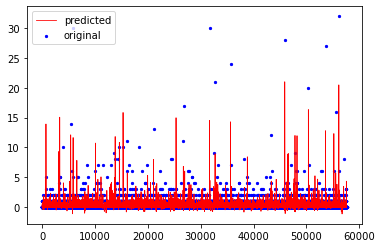

In [10]:
# plot the Actual vs. Estimated values
x_ax = range(len(Y_test))
plt.scatter(x_ax, Y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred_1, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [11]:
# r-square 
r2_score(Y_test, ypred_1)

0.4474466834709774

In [12]:
# save the coefficients to dataframe
c = list(data.columns.values[:-2])
p = list(para_in)
df_inflow = pd.DataFrame([c,p]).transpose()
df_inflow.columns = ['cat_code','inflow_parameter']
df_inflow['dayofweek'] = df_inflow.cat_code.astype(str).str[2:5]
df_inflow['cat_code'] = df_inflow.cat_code.astype(str).str[-8:-2]
df_inflow

,cat_code,inflow_parameter,dayofweek
0,400_S1,0.376697,MON
1,500_S1,-0.228993,MON
2,550_S1,-0.088265,MON
3,600_S1,0.004984,MON
4,700_S1,0.025285,MON
...,...,...,...
299,200_S5,0.061089,SUN
300,500_S5,0.026559,SUN
301,100_S6,0.002757,SUN
302,200_S6,0.015717,SUN


## outflow modelling

In [13]:
dataset1 =pd.read_csv('output/dataset(x_y)_OP_L1_week_cleaned.csv')

data = dataset1.drop(columns=['time_interval','dayofweek','zonecode'])
data

,"('MONDAY', '400_S1')","('MONDAY', '500_S1')","('MONDAY', '550_S1')","('MONDAY', '600_S1')","('MONDAY', '700_S1')","('MONDAY', '800_S1')","('MONDAY', '900_S1')","('MONDAY', '100_S2')","('MONDAY', '200_S2')","('MONDAY', '300_S2')",...,"('SUNDAY', '800_S4')","('SUNDAY', '900_S4')","('SUNDAY', '100_S5')","('SUNDAY', '200_S5')","('SUNDAY', '500_S5')","('SUNDAY', '100_S6')","('SUNDAY', '200_S6')","('SUNDAY', '500_S6')",outflow_median,inflow_median
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
230409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# extract x and y
x = data.drop(columns= ['inflow_median','outflow_median'])
y2 = data['outflow_median']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y2, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(172809, 304)
(57603, 304)
(172809,)
(57603,)


In [16]:
lars = linear_model.Lars().fit(X_train, Y_train)

In [17]:
para_out = lars.coef_

In [18]:
ypred_2 = lars.predict(X_test)
mse = mean_squared_error(Y_test, ypred_2)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % sqrt(mse))

MSE: 0.14
RMSE: 0.37


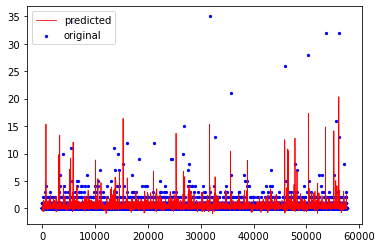

In [20]:
x_ax = range(len(Y_test))
plt.scatter(x_ax, Y_test, s=5, color="blue", label="original")
plt.plot(x_ax, ypred_2, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [21]:
r2_score(Y_test, ypred_2)

0.4169464957292508

In [22]:
def mape(y_true, y_pred):
    df = pd.DataFrame(columns = ['y_true', 'y_pred'])
    df['y_true'] = y_true
    df['y_pred'] = y_pred
    df = df[df.y_true > 0]
    return np.mean(np.abs((df.y_pred - df.y_true) / df.y_true)) * 100

mape(Y_test, ypred_2)

85.78385450616472

In [23]:
c = list(data.columns.values[:-2])
p = list(para_out)
df_outflow = pd.DataFrame([c,p]).transpose()
df_outflow.columns = ['cat_code','outflow_parameter']
df_outflow['dayofweek'] = df_outflow.cat_code.astype(str).str[2:5]
df_outflow['cat_code'] = df_outflow.cat_code.astype(str).str[-8:-2]
df_outflow

,cat_code,outflow_parameter,dayofweek
0,400_S1,0.189418,MON
1,500_S1,-0.071766,MON
2,550_S1,-0.036054,MON
3,600_S1,-0.00322,MON
4,700_S1,0.029669,MON
...,...,...,...
299,200_S5,0.054597,SUN
300,500_S5,0.004377,SUN
301,100_S6,0.019045,SUN
302,200_S6,-0.026289,SUN


In [24]:
df_para= df_outflow.merge(df_inflow,on=['cat_code','dayofweek'])
df_para

,cat_code,outflow_parameter,dayofweek,inflow_parameter
0,400_S1,0.189418,MON,0.376697
1,500_S1,-0.071766,MON,-0.228993
2,550_S1,-0.036054,MON,-0.088265
3,600_S1,-0.00322,MON,0.004984
4,700_S1,0.029669,MON,0.025285
...,...,...,...,...
299,200_S5,0.054597,SUN,0.061089
300,500_S5,0.004377,SUN,0.026559
301,100_S6,0.019045,SUN,0.002757
302,200_S6,-0.026289,SUN,0.015717
